In [1]:
import pandas as pd
bus_df = pd.read_csv('test.csv')

In [2]:
from datetime import datetime
def parse_time(timestamp):
    """
    'YYYY-MM-DD HH:MM:SS AM/PM', 'YYYY-MM-DD HH:MM:SS', 또는 'YYYY-MM-DD HH:MM' 형식을 파싱하는 함수
    """
    timestamp = timestamp.split('.')[0]
    try:
        # 먼저 24시간 형식으로 파싱 시도
        return datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    except ValueError:
        try:
            # 실패하면 12시간 형식으로 파싱 시도
            return datetime.strptime(timestamp, '%Y-%m-%d %I:%M:%S %p')
        except ValueError:
            # 실패하면 'YYYY-MM-DD HH:MM' 형식으로 파싱 시도
            return datetime.strptime(timestamp, '%Y-%m-%d %H:%M')

In [3]:
bus_df['timestamp'] = bus_df['Parsed_Date'].apply(parse_time)
bus_df.dtypes

MASK_SELECTED                 int64
LAT                         float64
LNG                         float64
STOP_ID                       int64
Parsed_Date                  object
up_down                       int64
temperature                 float64
Relative_Humidity           float64
is_weekend                     bool
day_name                     object
previous                    float64
wind_d                      float64
wind_s                      float64
Bus_num                       int64
prev_arrive_time             object
start_time                   object
travel_time                 float64
timestamp            datetime64[ns]
dtype: object

In [4]:
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# 데이터 전처리 함수
def preprocess_data(data, sequence_length=28, train_ratio=0.8, val_ratio=0.15):
    # 주기성 변환
    data["stop_sin"] = np.sin(2 * np.pi * data["MASK_SELECTED"] / sequence_length)
    data["stop_cos"] = np.cos(2 * np.pi * data["MASK_SELECTED"] / sequence_length)
    data["hour"] = data["timestamp"].dt.hour
    data["hour_sin"] = np.sin(2 * np.pi * data["hour"] / 24)
    data["hour_cos"] = np.cos(2 * np.pi * data["hour"] / 24)
    
    # 원핫 인코딩 적용
    data = pd.get_dummies(data, columns=['day_name', ])
   

    # 필요없는 열 제거 및 텐서 변환 준비
    features = data[[
        "MASK_SELECTED", "temperature", "LAT", "LNG", "Relative_Humidity", 'wind_d', 'wind_s', 'is_weekend',
        "previous", "stop_sin", "hour_sin", "stop_cos", "hour_cos", 'day_name_Monday', 'day_name_Saturday', 'day_name_Sunday',
       'day_name_Thursday', 'day_name_Tuesday', 'day_name_Wednesday'
    ]].values
    target = data["travel_time"].values.reshape(-1, 1)

    # 스케일링 적용
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    features_scaled = scaler_features.fit_transform(features)  # timestamp 포함
    target_scaled = scaler_target.fit_transform(target)

    # 데이터셋 분할 및 시퀀스 생성 함수
    num_sequences = len(features_scaled) // sequence_length
    train_size = int(num_sequences * train_ratio) * sequence_length
    val_size = int(num_sequences * val_ratio) * sequence_length
    
    X_train = features_scaled[:train_size]
    y_train = target_scaled[:train_size]
    
    X_val = features_scaled[train_size:train_size + val_size]
    y_val = target_scaled[train_size:train_size + val_size]
    
    X_test = features_scaled[train_size + val_size:]
    y_test = target_scaled[train_size + val_size:]
    
    # 시퀀스 데이터 생성 함수
    def create_sequences(X, y, seq_length):
        sequences = []
        targets = []
        for i in range(0, len(X) - seq_length + 1, seq_length):
            sequences.append(X[i:i + seq_length])
            targets.append(y[i:i + seq_length])
        return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

    # 학습, 검증, 테스트 데이터셋 생성
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)
    
    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, scaler_target


In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# DataLoader 생성
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test):
    
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()
    X_val = torch.tensor(X_val).float()
    y_val = torch.tensor(y_val).float()
    X_test = torch.tensor(X_test).float()
    y_test = torch.tensor(y_test).float()

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    # batch_size=None 또는 데이터셋 크기만큼 설정
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, test_loader


Channel_attention

In [6]:
import torch
import torch.nn as nn

# SEBlock 구현
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)  # Squeeze
        y = self.fc(y).view(b, c, 1, 1)  # Excitation
        return x * y.expand_as(x)  # Scale

ConvLstm

In [7]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv = nn.Conv2d(
            input_dim + hidden_dim,
            4 * hidden_dim,
            kernel_size,
            padding=kernel_size // 2
        )

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_dim, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c

ConvLstmEncodeDecoder

In [8]:
import torch
import torch.nn as nn

class SimpleConvLSTMSE(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, output_dim, seq_len, reduction=16):
        super(SimpleConvLSTMSE, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        # 단일 ConvLSTMCell
        self.conv_lstm = ConvLSTMCell(input_dim, hidden_dim, kernel_size)

        # 단일 SEBlock
        self.se_block = SEBlock(hidden_dim, reduction)

        # Fully Connected Layer for final output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, input_seq_len, channels, height, width = x.size()

        # ConvLSTM 초기 hidden state와 cell state
        h = torch.zeros(batch_size, self.hidden_dim, height, width, device=x.device)
        c = torch.zeros(batch_size, self.hidden_dim, height, width, device=x.device)

        # ConvLSTM 처리
        for t in range(input_seq_len):
            h, c = self.conv_lstm(x[:, t, :, :, :], h, c)
            h = self.se_block(h)  # SEBlock 적용

        # h의 마지막 상태를 Flatten 후 Fully Connected Layer에 입력
        h_flat = h.view(batch_size, -1)
        output = self.fc(h_flat)

        return output  # (batch_size, output_dim)



Early Stopping

In [9]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): 얼마나 많은 에폭 동안 검증 손실이 개선되지 않아도 학습을 계속할지.
            verbose (bool): True일 경우, 각 개선 사항을 출력.
            delta (float): 개선으로 간주하기 위한 최소 변화.
            path (str): 최상의 모델을 저장할 경로.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # 손실이 낮을수록 좋으므로 음수로 변환

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''검증 손실이 감소하면 모델을 저장'''
        if self.verbose:
            print("===================================saved===================================")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


Scheduler

In [10]:
import torch.optim as optim

def get_scheduler(optimizer, mode='min', factor=0.1, patience=5, verbose=True):
    """
    학습률 스케줄러를 반환하는 함수.

    Args:
        optimizer (torch.optim.Optimizer): 최적화 알고리즘.
        mode (str): 모니터링할 지표의 방향 ('min' 또는 'max').
        factor (float): 학습률 감소 비율.
        patience (int): 학습률을 감소시키기 전에 기다릴 에폭 수.
        verbose (bool): True일 경우, 학습률 변경 시 로그를 출력.

    Returns:
        torch.optim.lr_scheduler.ReduceLROnPlateau: 학습률 스케줄러.
    """
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode=mode,
        factor=factor,
        patience=patience,
        verbose=verbose
    )
    return scheduler


Train

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 준비
data = bus_df
X_train, y_train, X_val, y_val, X_test, y_test, scaler_target = preprocess_data(data)

# DataLoader 생성
train_loader, val_loader, test_loader = create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test)

# 모델 정의
input_dim = 19 # 입력 차원 크기 설정
hidden_dim = 64  # 적절히 설정된 hidden dimension
kernel_size = 3
num_layers = 2
output_dim = 1
reduction = 16
seq_len = 1
model = SimpleConvLSTMSE(input_dim, hidden_dim, kernel_size, output_dim, seq_len,).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 설정
scheduler = get_scheduler(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early Stopping 초기화
early_stopping = EarlyStopping(patience=20, verbose=True, path='batch32/conv_model.pt')

# 학습 및 평가 함수
def train_and_evaluate_seq(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping):
    model.to(device)
    for epoch in range(num_epochs):
        # =================== Training ===================
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            # 배치 데이터를 디바이스로 이동
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # 입력 텐서에 height와 width 차원을 추가하여 5차원으로 변환
            # 기존: (batch_size, seq_len, channels)
            # 변경 후: (batch_size, seq_len, channels, 1, 1)
            batch_X = batch_X.unsqueeze(-1).unsqueeze(-1).unsqueeze(1)
            
            
            # 모델 예측 및 손실 계산
            output = model(batch_X)  # 출력: (batch_size, seq_len, output_dim)
            loss = criterion(output, batch_y)  # batch_y: (batch_size, seq_len, output_dim)
            
            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        # 평균 학습 손실 계산
        train_loss /= len(train_loader)
            
        # =================== Validation ===================
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                batch_X = batch_X.unsqueeze(-1).unsqueeze(-1).unsqueeze(1)
                output = model(batch_X)  # 출력: (batch_size, seq_len, output_dim)
                loss = criterion(output, batch_y)  # batch_y: (batch_size, seq_len, output_dim)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # =================== Early Stopping ===================
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 학습이 중단된 후 최적의 모델 로드
    model.load_state_dict(torch.load('batch32/conv_model.pt'))

# 학습 실행
num_epochs = 1000
train_and_evaluate_seq(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping)

# 테스트 단계에서의 평가
model.eval()
test_mse = 0.0
total_samples = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        # 데이터를 GPU로 이동
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # 입력 텐서에 height와 width 차원을 추가하여 5차원으로 변환
        batch_X = batch_X.unsqueeze(-1).unsqueeze(-1).unsqueeze(1)
        
        # 모델 예측 수행
        output = model(batch_X)  # 출력: (batch_size, seq_len, output_dim)
        
        # 손실 계산
        loss = criterion(output, batch_y)  # batch_y: (batch_size, seq_len, output_dim)
        test_mse += loss.item() * batch_X.size(0)
        total_samples += batch_X.size(0)

# 평균 MSE 계산
average_test_mse = test_mse / total_samples
print(f"Test MSE: {average_test_mse:.6f}")

# RMSE 계산
average_test_rmse = average_test_mse ** 0.5  # MSE의 제곱근을 취해 RMSE 계산
print(f"Test RMSE: {average_test_rmse:.6f}")


/tmp/ipykernel_300565/4158508312.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
/tmp/ipykernel_300565/4158508312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
/tmp/ipykernel_300565/4158508312.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val).float()
/tmp/ipykernel_300565/4158508312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach()

ValueError: too many values to unpack (expected 5)

In [78]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# 최적의 모델 로드
model.load_state_dict(torch.load('batch32/conv_model.pt'))

# 모델 평가 모드 설정
model.eval()

# 예측 결과와 실제값을 저장할 리스트 생성
predictions = []
actuals = []

# 예측 및 실제값 계산
with torch.no_grad():
    for batch in test_loader:
        # 배치에서 수치형 데이터와 타겟 값 분리
        batch_X, batch_y = batch[0].to(device), batch[1].to(device)
        batch_X = batch_X.unsqueeze(-1).unsqueeze(-1).unsqueeze(1)
        # 모델 예측
        output = model(batch_X)

        # 출력값과 타겟값의 차원을 일관되게 유지
        output = output.squeeze(-1)  # 예측값에서 불필요한 마지막 차원 제거
        batch_y = batch_y.squeeze(-1)  # 타겟값에서도 불필요한 마지막 차원 제거

        # 예측값과 실제값을 리스트에 저장
        predictions.append(output.cpu().numpy())  # GPU에서 CPU로 이동 후 numpy 변환
        actuals.append(batch_y.cpu().numpy())     # GPU에서 CPU로 이동 후 numpy 변환

# Flatten and inverse scale
predictions = np.concatenate(predictions, axis=0)  # 배치별 예측값을 하나의 배열로 결합
actuals = np.concatenate(actuals, axis=0)          # 배치별 실제값을 하나의 배열로 결합

# 예측값과 실제값을 2차원 배열로 변환 (MinMaxScaler 사용을 위해)
predictions = predictions.reshape(-1, 1)
actuals = actuals.reshape(-1, 1)

# 예측값과 실제값의 스케일 복원
predictions_original = scaler_target.inverse_transform(predictions)
actuals_original = scaler_target.inverse_transform(actuals)

# 데이터프레임으로 저장
results_df = pd.DataFrame({
    "Actual": actuals_original.flatten(),
    "Predicted": predictions_original.flatten()
})

# CSV 파일로 저장
results_df.to_csv("test_predictions.csv", index=False)

# MSE 계산
mse = mean_squared_error(actuals_original, predictions_original)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Squared Error (RMSE): {rmse}")
print("예측 결과가 test_predictions.csv 파일로 저장되었습니다.")


/tmp/ipykernel_104969/751042663.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('batch32/conv_model.pt'))


Mean Squared Error (MSE): 1711.1064453125
Mean Squared Error (RMSE): 41.36552429199219
예측 결과가 test_predictions.csv 파일로 저장되었습니다.


before ConvLstm

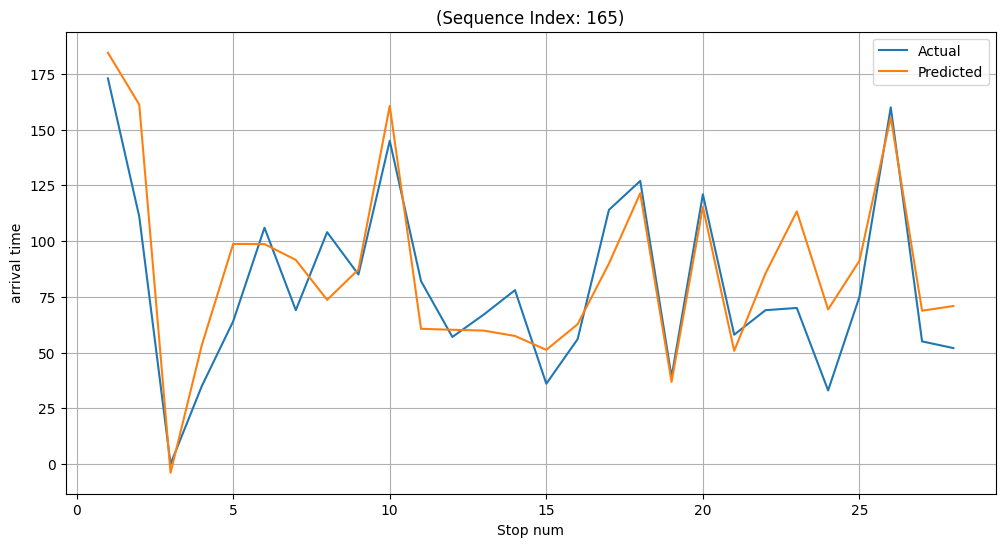

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# CSV 파일 읽기
df = pd.read_csv('test_predictions.csv')

# 시퀀스 길이 설정 (버스 정류장 수)
sequence_length = 28

# 시퀀스 생성
sequences = []
for i in range(0, len(df), sequence_length):
    seq = df.iloc[i:i+sequence_length]
    if len(seq) == sequence_length:
        sequences.append(seq)

# 각 시퀀스에 대한 MAE 계산
mse_list = []
for seq in sequences:
    mse = np.mean((seq['Actual'].values - seq['Predicted'].values) ** 2)
    mse_list.append(mse)

# 가장 MAE가 작은 시퀀스의 인덱스 찾기
best_sequence_index = np.argmin(mse_list)
best_sequence = sequences[best_sequence_index]

# 실제 값과 예측 값 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(range(1, sequence_length+1), best_sequence['Actual'], label='Actual', marker='')
plt.plot(range(1, sequence_length+1), best_sequence['Predicted'], label='Predicted', marker='')
plt.title('(Sequence Index: {})'.format(best_sequence_index))
plt.xlabel('Stop num')
plt.ylabel('arrival time')
plt.legend()
plt.grid(True)
plt.show()
